## Social network visualization based on twitter's tag co-occurrences

In [13]:
import networkx as nx
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import os
import openai
from collections import Counter
import re
import pandas as pd
import requests
import pytrends
from pytrends.request import TrendReq
import tweepy
import itertools
from collections import Counter
import os
import openai
import pytrends
from pytrends.request import TrendReq
import matplotlib.pyplot as plt

f = open('twitter_apikey.txt','r')
key = f.read().split()[0]

### Functions

In [14]:

def retrieve_data(keyword, key, domain = ""):
    """
    Method to retrieve 1000 tweets from twitter with tweepy
    """
    if domain != "":
        query = keyword + " " + domain
    else:
        query = keyword
        
        
    client = tweepy.Client(bearer_token=key)
    tweets = tweepy.Paginator(client.search_recent_tweets, query=query,
                                max_results=100).flatten(limit=1000)    

    tweets_lst=[tweet.text for tweet in tweets]
    print("number of tweets retrieved: ", len(tweets_lst)) 
    
    return tweets_lst


def counter(tweets):
    """
    Method to count hasthags in tweets
    """
    hashtags=[]
    for tweet in tweets:
        for word in tweet.split():
            if "#" in word:
                hashtags.append(word.lower().strip("#").strip(","))
                
    print("number of hastags: ", len(hashtags))
    return Counter(hashtags)



def extract_tags(tweets):
    """
    Method to create list of lists of hashatgs (for each tweet)
    """

    hashtags=[]
    for tweet in tweets:
        tweet_hashtags=[]
        for word in tweet.split():
            if "#" in word:
                tweet_hashtags.append(word.lower().strip("#").strip(",").strip(":").strip("/"))
        hashtags.append(tweet_hashtags)
 
    return hashtags


def count_occurrences(hashtags):
    """
    Method to count the co-occorrunces of each tag, and sort them
    """

    combinations_count=[list(itertools.combinations(tags_tweet, 2)) for tags_tweet in hashtags]
 
    flat = [x for sublist in combinations_count for x in sublist] #flatten list to 1 dimension

    occurrences = Counter(flat)

    sorted_dict = {}
    sorted_keys = sorted(occurrences, key=occurrences.get)  

    for w in sorted_keys:
        sorted_dict[w] = occurrences[w]

    keys=list(sorted_dict.keys())
    values=list(sorted_dict.values())
    
    return keys, values




def visualize_relations(keys, values, count):
    """
    Visualize the relationships between the related terms with a social network
    """
    plt.style.use('seaborn-dark')
    # network visualization

    keys=keys[-50:]
    values=values[-50:]

    plt.figure(figsize=(17, 13))

    # code re-adapted from https://qxf2.com/blog/drawing-weighted-graphs-with-networkx/

    # add nodes
    G = nx.Graph() #Create a graph object called G
    node_list = keys  # the nodes are the hashtags

    dimension={}
    for i in node_list: # create dictionary that contains the recurrence of every hashtag, which will define the dimension of the node
        for j in i:
            dimension[j]=count[j]  


    for i in node_list:  # for loop to add nodes to plot
        for j in i:
            G.add_node(j, size=dimension[j]*5)

    pos=nx.spring_layout(G, seed=7) 

    max_dim = max(dimension.values())
    node_size=[(i*100/max_dim)*80 for i in dimension.values()]  
    color= [i for i in sns.color_palette()]*4
    nx.draw_networkx_nodes(G, pos, node_color=color[:len(G)], node_size=node_size, alpha=0.7)  # draw the nodes


    labels = {}
    for i in node_list:
        for j in i:
            labels[str(j)] =str(j)
    nx.draw_networkx_labels(G,pos,labels,font_size=16)

    # add edges
    for i, el in enumerate(keys):
        G.add_edge(el[0],el[1], weight=values[i])

    all_weights = []

    # gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness

    # get unique weights
    unique_weights = list(set(all_weights))

    # plot the edges - one by one
    for weight in unique_weights:
        # Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner
        width = weight*len(node_list)*8.0/sum(all_weights)
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, alpha=0.3)

    #Plot the graph
    plt.axis('off')
    plt.title('trend relationships')
    plt.show() 


In [15]:
# input topic

string = input("Topic: ")
domain = input("Domain: ")

number_articles= 50 # input("Enter number of articles to retrieve (50, 100, 150...): ")

if "#" in string:
    query =  string +' -is:retweet lang:en'
else:
    query =  "#" + string.replace(" ", "") +' -is:retweet lang:en'


Topic: nlp
Domain: deep learning


### Social Network

number of tweets retrieved:  79
number of hastags:  601


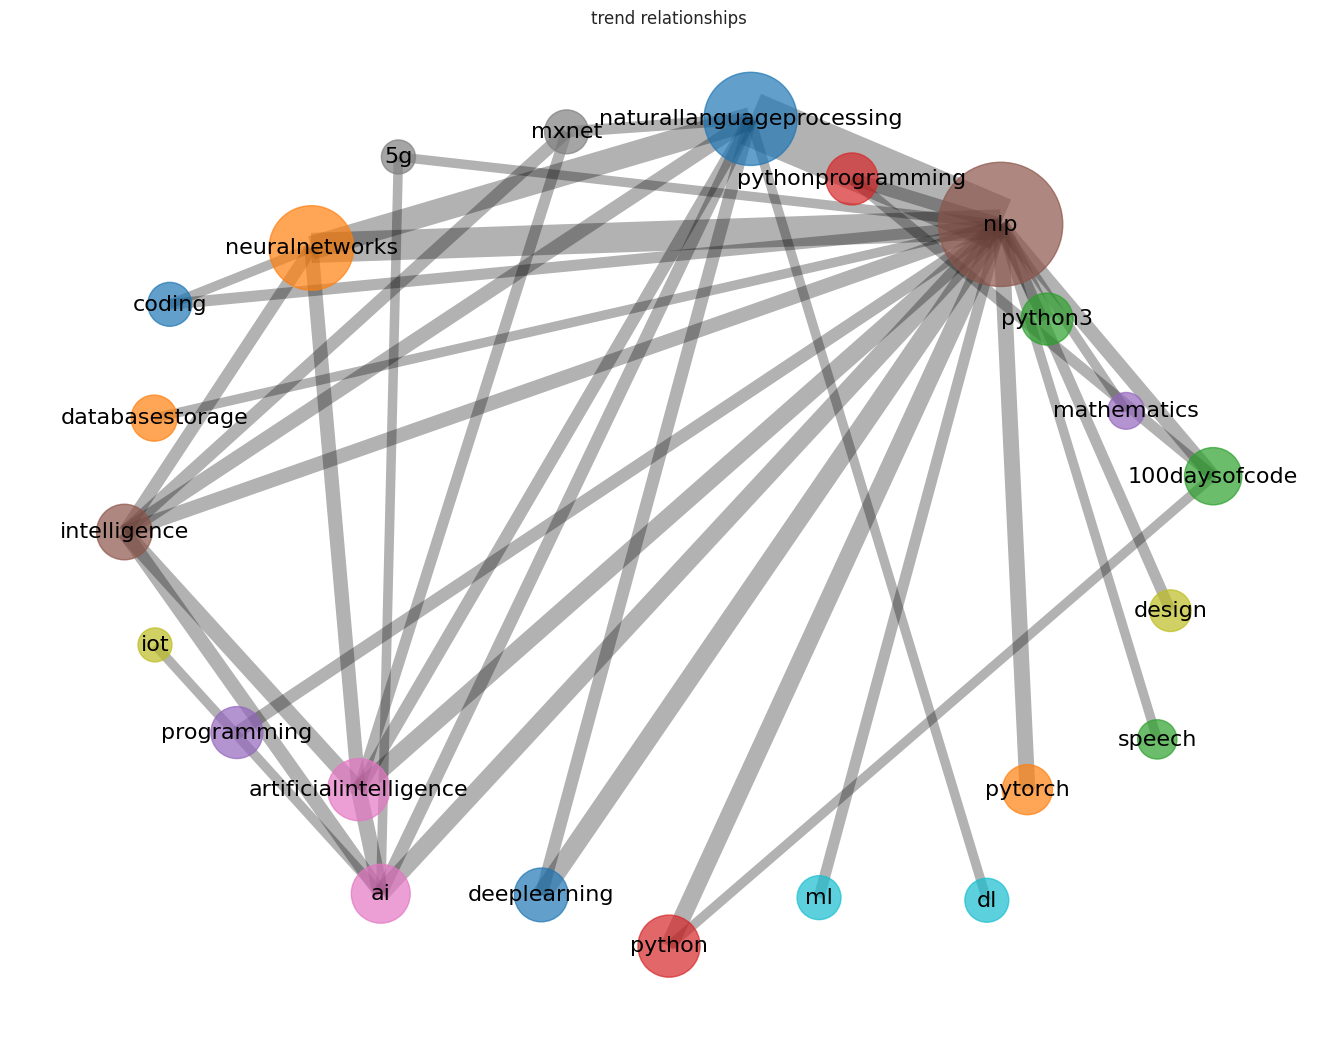

In [16]:
# retrieving data for network visualization

data = retrieve_data(query, key, domain)
count = counter(data)
hashtags = extract_tags(data)
keys, values = count_occurrences(hashtags)
visualize_relations(keys, values, count)